In [1]:
import intake
import os.path
import xarray as xr
from utils import plotter
from analogs import calculate_analogs, load_LENS_dataset, print_analog_stats, plot_analog_validation
import xesmf as xe
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib
import cartopy

k = 5

In [2]:
# lat, lon = 33.1072795,35.4688208
lat, lon = 20.194824,-100.9225607

In [3]:
URL = "/home/jhexr/code/clustering_analogs/data/aws-cesm1-le.json"
if not os.path.isfile(URL):
    URL = "https://ncar-cesm-lens.s3-us-west-2.amazonaws.com/\
        catalogs/aws-cesm1-le.json"
    LENS_dataset = load_LENS_dataset(URL)
    LENS_dataset.to_netcdf("./data/Lens_dataset.nc")
else:
    LENS_dataset = xr.open_dataset('./data/Lens_dataset.nc')
    print(LENS_dataset)

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, member_id: 40, time: 181)
Coordinates:
  * time       (time) object 1920-01-01 00:00:00 ... 2100-01-01 00:00:00
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
Data variables:
    TREFHT     (member_id, time, lat, lon) float32 ...
    PRECC      (member_id, time, lat, lon) float32 ...


In [4]:
nc_file = './data/gto_cesm.nc'
if not os.path.isfile(nc_file):
    curr_analogs = calculate_analogs(
        LENS_dataset, lat, lon, 
        ['TREFHT', 'PRECC'], LENS_dataset, 
        '2000-01-01', '2009-12-31', 
        '2000-01-01', '2009-12-31')
    curr_analogs = curr_analogs.load()
    print("Done")
    print(curr_analogs)
    curr_analogs.to_netcdf('./data/gto_cesm.nc')
else:
    curr_analogs = xr.load_dataset('./data/gto_cesm.nc')

In [5]:
curr_distances = curr_analogs['Standardized Euclidean Distance'].mean(dim='member_id')
da = curr_distances
cmap = 'Greens_r'
title = 'Current Climate Analogs for 2000-2009 Hula'
vmin = 0
vmax = 3
location=(lon,lat)
mask_out_ocean = True
cbar_ylabel=None

In [6]:
# mask ocean
if mask_out_ocean:
    import xesmf as xe
    ds_in = xr.open_dataset("./data/lsmask.oisst.v2.nc")
    regridder = xe.Regridder(ds_in, da, 'nearest_s2d', reuse_weights=True)
    ds_in = regridder(ds_in).squeeze()
    da.values[ds_in['lsmask'] == 1] = np.nan

Reuse existing file: nearest_s2d_720x1440_192x288.nc
using dimensions ('lat', 'lon') from data variable lsmask as the horizontal dimensions for this dataset.


In [7]:
da_min = da.where(da != da.sel(lat=lat, lon=lon, method='nearest'))

df = da_min.to_dataframe().dropna()
df.reset_index(inplace=True)
print(df)

             lat     lon  Standardized Euclidean Distance
0     -90.000000    0.00                        36.365845
1     -90.000000    1.25                        36.285984
2     -90.000000    2.50                        36.281197
3     -90.000000    3.75                        36.278149
4     -90.000000    5.00                        36.366158
...          ...     ...                              ...
18473  83.403145  327.50                        23.556850
18474  83.403145  328.75                        23.543150
18475  83.403145  330.00                        23.494827
18476  83.403145  331.25                        23.432343
18477  83.403145  332.50                        23.290562

[18478 rows x 3 columns]


In [8]:
import pandas as pd
from sklearn import preprocessing

x = df[['Standardized Euclidean Distance']].values #returns a numpy array

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df['Standardized Euclidean Distance'] = pd.DataFrame(x_scaled)
print(df)


             lat     lon  Standardized Euclidean Distance
0     -90.000000    0.00                         0.342227
1     -90.000000    1.25                         0.341467
2     -90.000000    2.50                         0.341422
3     -90.000000    3.75                         0.341393
4     -90.000000    5.00                         0.342230
...          ...     ...                              ...
18473  83.403145  327.50                         0.220329
18474  83.403145  328.75                         0.220199
18475  83.403145  330.00                         0.219739
18476  83.403145  331.25                         0.219144
18477  83.403145  332.50                         0.217795

[18478 rows x 3 columns]


In [9]:
quan = 0.1
print(df['Standardized Euclidean Distance'].quantile(quan))

0.02138181384652853


In [10]:
df['temp'] = ""
df.loc[df['Standardized Euclidean Distance'] > df['Standardized Euclidean Distance'].quantile(quan), 'temp'] = np.nan
df.loc[df['Standardized Euclidean Distance'] < df['Standardized Euclidean Distance'].quantile(quan), 'temp'] = 1
print(df['Standardized Euclidean Distance'].quantile(0.1))


df = df.dropna()
df = df.drop(columns=['Standardized Euclidean Distance','temp'])
print(df)

0.06348180323839188
             lat     lon
6117  -28.743456  135.00
6178  -27.801046  135.00
6179  -27.801046  136.25
6180  -27.801046  137.50
6181  -27.801046  138.75
...          ...     ...
11023  32.513088   46.25
11024  32.513088   47.50
11087  32.513088  247.50
11202  33.455498  246.25
11203  33.455498  247.50

[370 rows x 2 columns]


             lat     lon
6117  -28.743456  135.00
6178  -27.801046  135.00
6179  -27.801046  136.25
6180  -27.801046  137.50
6181  -27.801046  138.75
...          ...     ...
11023  32.513088   46.25
11024  32.513088   47.50
11087  32.513088  247.50
11202  33.455498  246.25
11203  33.455498  247.50

[370 rows x 2 columns]


Text(0, 0.5, 'Lat')

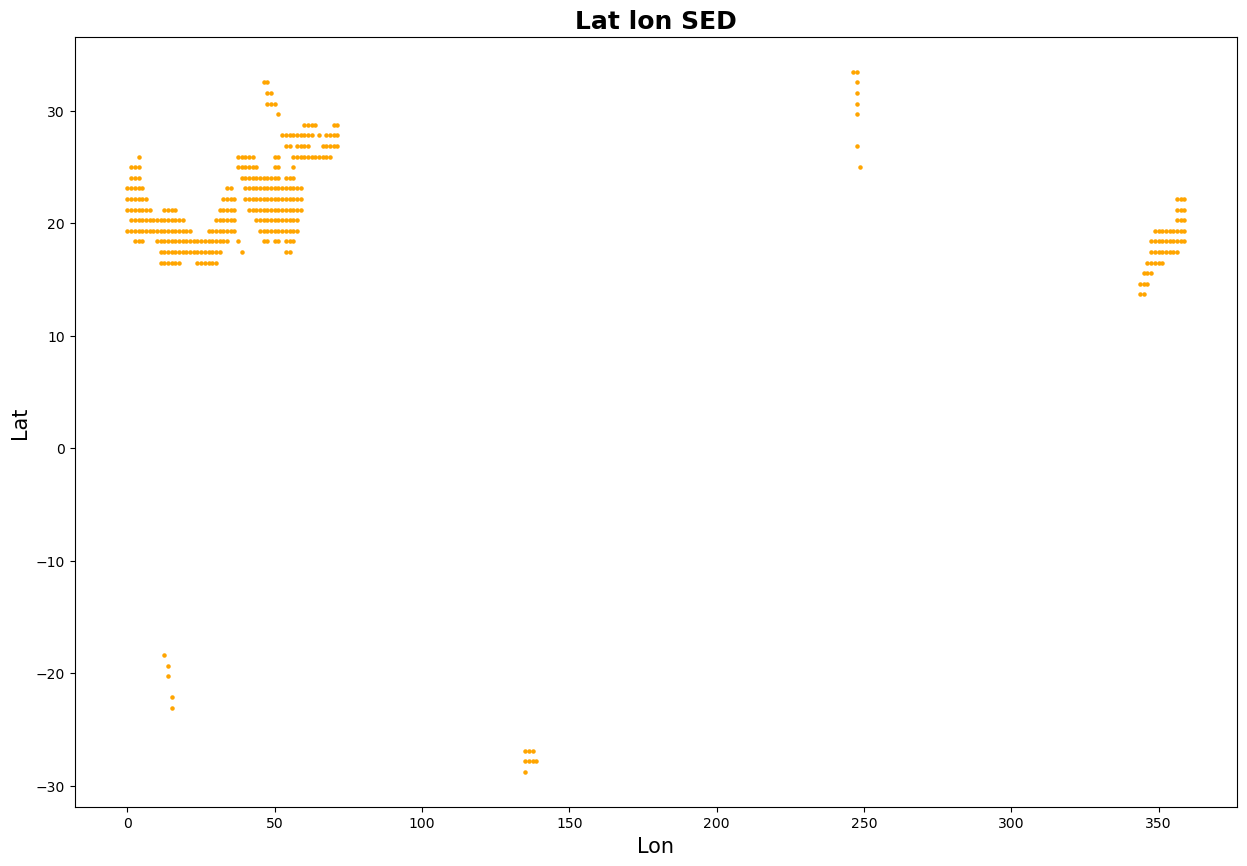

In [11]:
print(df)
from sklearn.cluster import KMeans
plt.style.use('default')
x=np.array(df['lon'])
y=np.array(df['lat'])
plt.figure(figsize=(15, 10))
plt.scatter(x, y, s=5, cmap='viridis',c='orange',label='Analogs')
plt.title('Lat lon SED',fontsize=18, fontweight='bold')
plt.xlabel('Lon',fontsize=15)
plt.ylabel('Lat',fontsize=15)

In [12]:
from sklearn.cluster import KMeans
x=np.array(df['lon'])
y=np.array(df['lat'])
X = np.array(df.astype(float))
print(X)

[[-28.74345589 135.        ]
 [-27.80104637 135.        ]
 [-27.80104637 136.25      ]
 [-27.80104637 137.5       ]
 [-27.80104637 138.75      ]
 [-26.85863876 135.        ]
 [-26.85863876 136.25      ]
 [-26.85863876 137.5       ]
 [-23.08900452  15.        ]
 [-22.14659691  15.        ]
 [-20.26177979  13.75      ]
 [-19.31937218  13.75      ]
 [-18.37696266  12.5       ]
 [ 13.66492176 343.75      ]
 [ 13.66492176 345.        ]
 [ 14.60732937 343.75      ]
 [ 14.60732937 345.        ]
 [ 14.60732937 346.25      ]
 [ 15.54973793 345.        ]
 [ 15.54973793 346.25      ]
 [ 15.54973793 347.5       ]
 [ 16.49214745  11.25      ]
 [ 16.49214745  12.5       ]
 [ 16.49214745  13.75      ]
 [ 16.49214745  15.        ]
 [ 16.49214745  16.25      ]
 [ 16.49214745  17.5       ]
 [ 16.49214745  23.75      ]
 [ 16.49214745  25.        ]
 [ 16.49214745  26.25      ]
 [ 16.49214745  27.5       ]
 [ 16.49214745  28.75      ]
 [ 16.49214745  30.        ]
 [ 16.49214745 346.25      ]
 [ 16.49214745

In [13]:
kmeans = KMeans(n_clusters=k, random_state=0,max_iter=1000)
kmeansclus_nw = kmeans.fit(df)
predicted_kmeans_nw = kmeans.predict(X)
centers_nw = kmeansclus_nw.cluster_centers_
print(centers_nw)

[[-27.56544471 136.40625   ]
 [ 17.93567697  14.375     ]
 [ 18.12693668 352.11734694]
 [ 23.51019338  50.51675978]
 [ 30.39267015 247.5       ]]


Text(0, 0.5, 'lat')

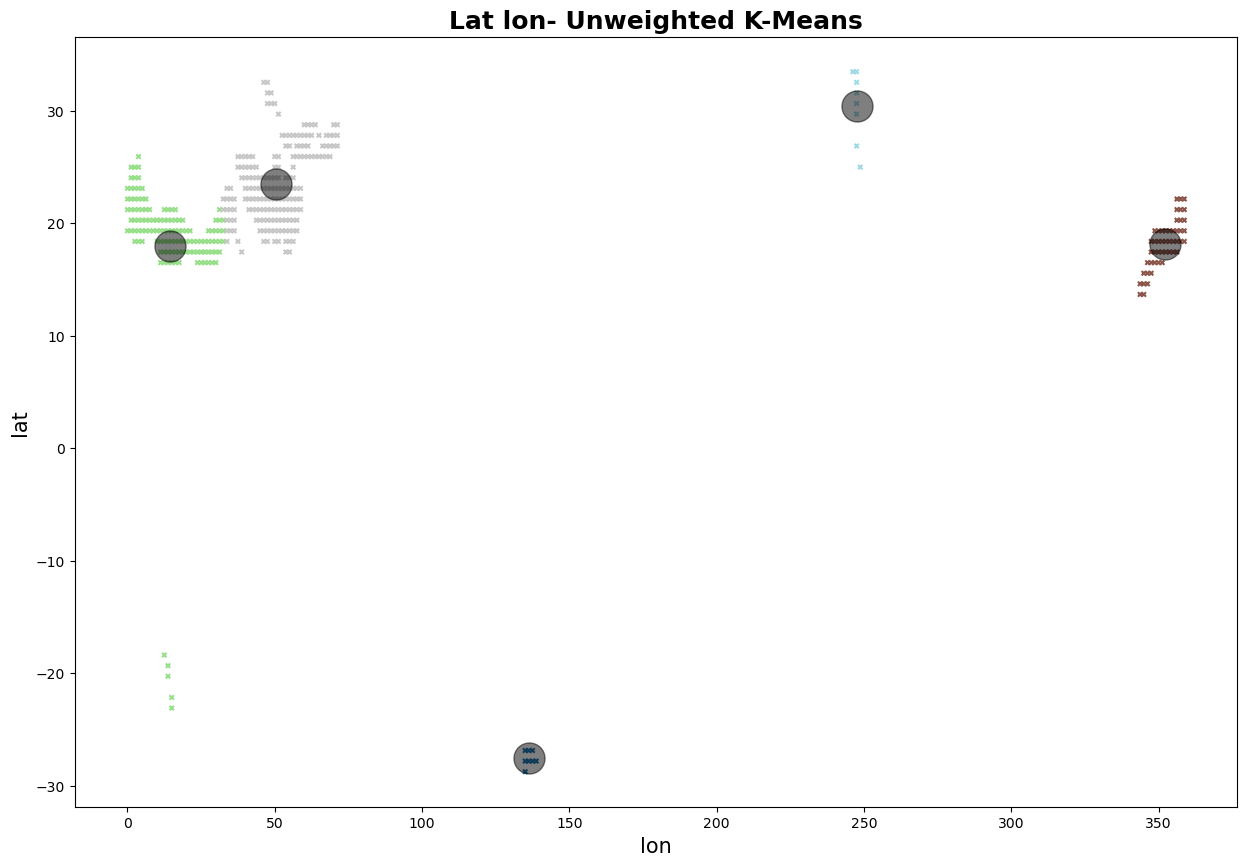

In [14]:
plt.figure(figsize=(15, 10))
plt.scatter(X[:, 1], X[:, 0], c=predicted_kmeans_nw, s=10, cmap='tab20',marker ='x')
plt.scatter(centers_nw[:, 1], centers_nw[:, 0], c='black', s=500, alpha=0.5);plt.title('Lat lon- Unweighted K-Means',fontsize=18, fontweight='bold')
plt.xlabel('lon',fontsize=15)
plt.ylabel('lat',fontsize=15)

In [15]:
top_k=[(p[1], p[0]) for p in centers_nw]
print(top_k)

[(136.40625, -27.565444707870487), (14.375000000000057, 17.935676968286895), (352.11734693877565, 18.126936678983718), (50.51675977653624, 23.51019338256153), (247.5, 30.392670154571512)]


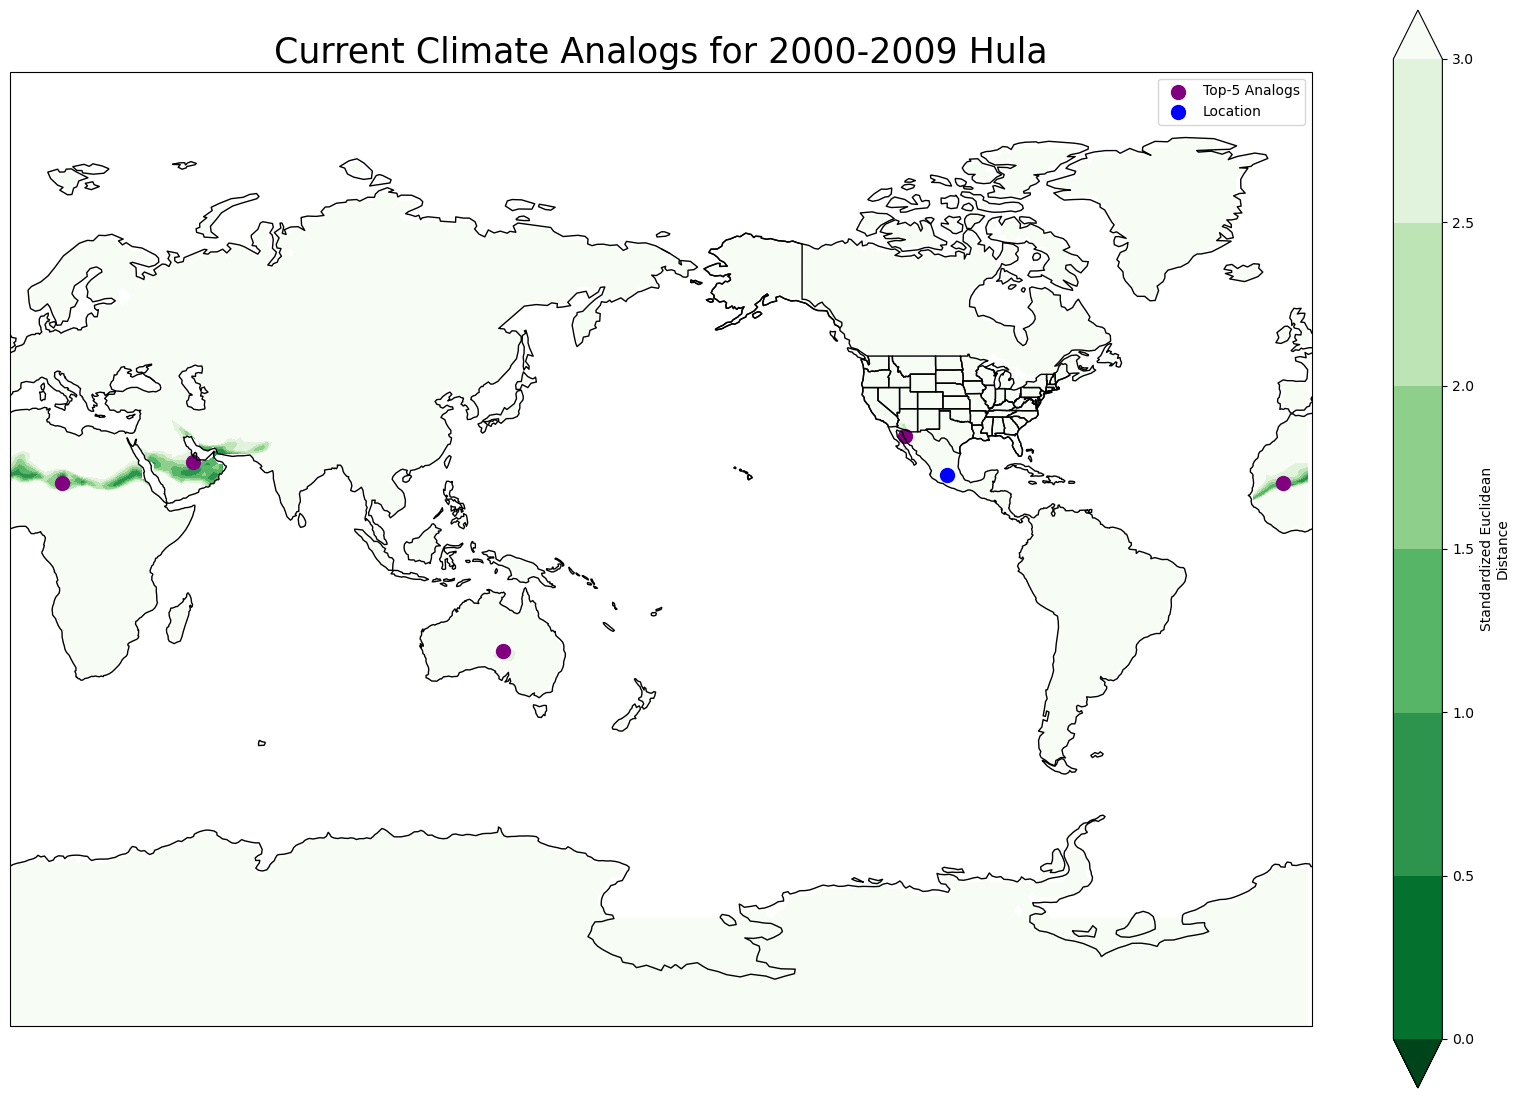

In [16]:
# plot
plt.figure(figsize=(21,14))
ax = plt.axes(projection=ccrs.Miller(central_longitude=180))
contours = da.plot.contourf(ax=ax, transform=ccrs.PlateCarree(),
    cmap=cmap, vmin=vmin, vmax=vmax, extend='both')
if cbar_ylabel:
    contours.colorbar.ax.set_ylabel(cbar_ylabel)
plt.title(title, size=25)
ax.set_global(); ax.coastlines(); ax.add_feature(cartopy.feature.STATES)

#plot points
if top_k:  
    ax.scatter([a[0] for a in top_k],[a[1] for a in top_k],
        transform=ccrs.PlateCarree(), color='purple',
        s=100, label = "Top-{} Analogs".format(k))
ax.scatter(*(location), transform=ccrs.PlateCarree(),
    color='blue', s=100, label="Location")
ax.legend()
plt.show()